

Inversion of the Moho depth using gravity gradient data
----------------------------------------

This Jupyter Notebook allows the inversion of gravity gradient data to estimate Moho depth and density contrast at the Moho depth. The script is designed to define a laterally variable density contrast. The extension of different density layers is based on seismological regionalization, which is a clustering product of the seismic tomographic model SL2013sv (Schaeffer & Lebedev, 2015). The regionalization defines different tectonic units in terms of their age. 

The script allows interactive calculation of the Bouguer anomaly, which is then used to invert for the Moho depth. This formulation allows to invert for the Moho depth at a study area as defined by the user. The coordinates of the study have to be inside a 1° window. At polar regions, the inversion might lead to inappropriate results, as the calculations are based on an equiangular grid of 1°.

The most important computation steps of the following script are:
1. Load the initial data files
2. Calculate Bouguer anomaly
3. Calculate reference Jacobian Matrix of inversion
4. Loop over different density contrasts and obtain final model
5. Plot the results

Step 2 and Step 3 calculates the gravitational effect of a model, converted from tesseroids to point masses, based on a code written by Wolfgang Szwillus.

For official use, please cite the paper: Haas, P., Ebbing J., Szwillus W. - Sensitivity analysis of gravity gradient inversion of the Moho depth – A case example for the Amazonian Craton, Geophysical Journal International, 2020, doi: 10.1093/gji/ggaa122


#### Load the Python packages that are required for the inversion

In [1]:
%matplotlib inline

import numpy as np
from grad_inv_functions import *
from topo_corr import *
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from matplotlib import cm,path
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import time
import progressbar
import os

# Here you have to include the path where the "proj4" is located (essential to use the Basemap package)
os.environ['PROJ_LIB'] = r'C:\Users\Peter\Anaconda3\pkgs\proj4-5.2.0-h6538335_1006\Library\share'
from mpl_toolkits.basemap import Basemap

#### Set parameters for the inversion

In [2]:
lon_min=-15 #Define coordinates of study area. 
lon_max=5
lat_min=-30
lat_max=-10

dx=1.0 # define grid cell size (should be 1.0 degree)
dy=1.0

farfield="no" # keep those values
sediments="no"

dens_min,dens_max,dens_inc=250.0,500.0,50
reference_moho=30000.0 # select value for reference Moho depth 

k=np.arange(dens_min,dens_max+0.1,dens_inc) # select range and increment of density contrast
beta=np.arange(1e-4,1.1e-4,1e-4) # select range and increment of smoothing parameter (should be constant)

# Define number of point masses the tesseroids are converted to. Should not be higher than 2
point_mass_number=2

# Define some initial conditions
dens_init=k[0]
lon=np.arange(lon_min,lon_max+dx,dx)
lat=np.arange(lat_min,lat_max+dy,dy)
longr,latgr = np.meshgrid(lon,lat)

#  Prepare vectors and grids for tesseroid model
lon=longr.flatten() 
lat=latgr.flatten()
height_km=225 
heights=np.ones(len(lon))*height_km*1000
area = (lat.min(), lat.max(), lon.min(), lon.max())
shape=np.array((abs(lat_max-lat_min)/dy+1,abs(lon_max-lon_min)/dx+1))
shape=shape.astype(int)

#### Set parameters for topographic correction

In [3]:
# Define area for Bouguer anomaly with overlap to avoid edge effects
overlap=5.0
area2 = (lat.min()-overlap, lat.max()+overlap, lon.min()-overlap, lon.max()+overlap)

#### Load and prepare the data

Seismic stations and tectonic units can be changed manually and are cut to the study area. The function "Doperator" calculates the smoothing matrix for the inversion using 2nd-order Tikhonov regularization.
The tectonic units are used to create density combinations and have to be organized as clusters.  


In [4]:
# Load and prepare seismic data
seismic_stations=np.loadtxt("Seismic_Moho_USGS_global.txt")
seismic_stations=cut_data_to_study_area(seismic_stations,area)
seismic_stations=seismic_stations[np.lexsort((seismic_stations[:,0],seismic_stations[:,1]))]

#Prepare Regularization
dmatrix_init=Doperator(shape,dx,dy)
smooth_matrix=np.eye(lon.size)*beta
dmatrix=dmatrix_init*beta

# Load and prepare seismological regionalization clustering analysis
tec_units=np.loadtxt('SL2013sv_Cluster_1d_interp.xyz')
tec_units=cut_data_to_study_area(tec_units,area)
tec_units=tec_units[np.lexsort((tec_units[:,0],tec_units[:,1]))]

# Counts the number of tectonic units of the regionalization (maximum 6 domains)
number_of_units=len(np.unique(tec_units[:,2]))
value_of_units=np.unique(tec_units[:,2])

# Creates the density matrix of all combinations of domains and density contrasts
dens_mat=create_density_combinations(k,number_of_units)

# This line can be activated to define only constant density contrasts. 
# Saves a lot of computational time, as only k combinations of density contrasts remain.
#dens_mat=(np.ones((len(k),number_of_units))*k).T  

# This line can be activated if only one SINGLE density combination is tested. 
# The values have to be defined manually and should only be selected if save_fields="yes" is activated.
#dens_mat=np.ones((1,6))*np.array([250,300,350,400,450,500])

rms_matrix=np.zeros((k.size**number_of_units,number_of_units+5))

#### Load Topography data for topographic correction

In [5]:
# Load and prepare topographic data
# Acknowledges Surface and Bedrock topography (based on ETOPO1, Amante & Eakins, 2009)
bed=np.loadtxt("ETOPO1_1degree_bed_global.txt")
bed2=np.copy(bed)
bed=cut_data_to_study_area(bed,area2)
bed=bed[np.lexsort((bed[:,0],bed[:,1]))]
ice=np.loadtxt("ETOPO1_1degree_ice_global.txt")
ice2=np.copy(ice)
ice=cut_data_to_study_area(ice,area2)
ice=ice[np.lexsort((ice[:,0],ice[:,1]))]


# Load gzz component of GOCE data
grav_data=np.loadtxt("gzz_1degree.txt")
grav_data2=np.copy(grav_data)
grav_data=cut_data_to_study_area(grav_data,area2)
grav_data=grav_data[np.lexsort((grav_data[:,0],grav_data[:,1]))]

#### Perform topographic correction
Creates a tesseroid model of topographic data, converts it to point masses and calculates the gravitational effect.

In [6]:
# Define coordinates and height for topographic correction with overlapping area
lon_grav=grav_data[:,0]
lat_grav=grav_data[:,1]
heights_grav=np.ones(len(lon_grav))*height_km*1000

In [7]:
topo_effect=topo_corr(lon_grav,lat_grav,bed,ice,heights_grav,point_mass_number)
bouguer=grav_data[:,2]-topo_effect

Calculate topographic effect
Calculate Jacobian
Calculation point mass No 1
Calculation point mass No 2
-4.736184119370926 -0.9464050197757755


Cut Bouguer anomaly back to study area 

In [8]:
bouguer=np.vstack((bed[:,0],bed[:,1],bouguer)).T
bouguer=cut_data_to_study_area(bouguer,area)
bouguer=np.copy(bouguer[:,2])

#### Have a look at the calculated Bouguer anomaly

##### Define plotting function

In [9]:
area_plot = (area[2],area[3],area[0],area[1])

bm = Basemap(projection='cyl', 
             llcrnrlon=area_plot[0], urcrnrlon=area_plot[1], 
             llcrnrlat=area_plot[2], urcrnrlat=area_plot[3],
             lon_0=0.5*(area_plot[0] + area_plot[1]), lat_0=0.5*(area_plot[3] + area_plot[2]), 
             resolution='l')

In [10]:
# Define plot function. Takes longitude, latitude and data as vectors. Takes min and max value of colourbar and levels 
# as integers; takes label of colourbar as string  

def plot_data(lon, lat, data, vmin, vmax, levels, cblabel, ranges=True):
    x=np.arange(lon.min(),lon.max()+1,dx)
    y=np.arange(lat.min(),lat.max()+1,dy)
    X, Y = np.meshgrid(x, y)
    data=np.reshape(data,(len(y),len(x)))
    fig = plt.figure(figsize=(14, 7))
    bm.pcolor(X, Y, data, cmap=cm.jet, vmin=vmin, vmax=vmax)
    bm.drawmeridians(np.arange(lon.min(), lon.max(), 10), labels=[0, 0, 0, 1], linewidth=0.2)
    bm.drawparallels(np.arange(lat.min(), lat.max(), 10), labels=[1, 0, 0, 0], linewidth=0.2)
    bm.drawcoastlines(color='grey')
    m = plt.cm.ScalarMappable(cmap=cm.jet)
    m.set_array(data)
    m.set_clim(vmin, vmax)
    plt.colorbar(m, boundaries=np.linspace(vmin, vmax, levels)).set_label(cblabel)
    plt.tight_layout(pad=0)

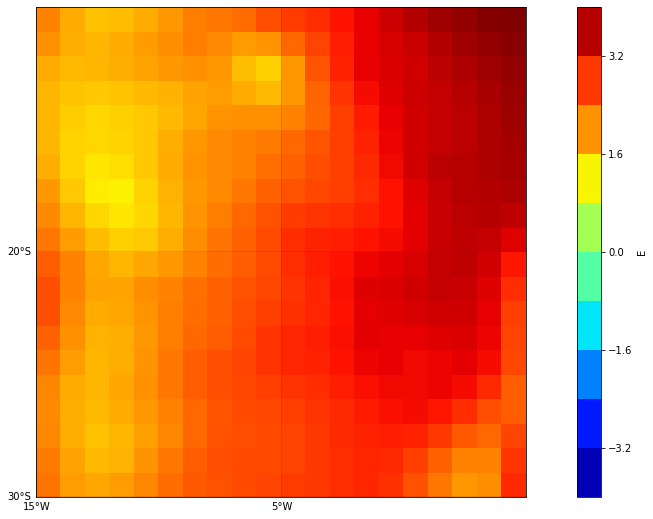

In [11]:
plot_data(lon,lat,bouguer,vmin=-4,vmax=4,levels=11, cblabel='E')

#### Inversion with single reference Moho depth and constant density contrast

The inversion of the gravity data is now performed once to obtain the reference Jacobian Matrix. Optionally, the inverted Moho depth as well as the residual field can be stored. 

In [12]:
# The "save-fields" function is intended to save the fields of a certain density contrast. 
# Should only be activated of a single density combination has been defined before.

save_fields="no" #select "yes" to save the computed fields as gridded data-files

# Prepare initial Moho depth, Create flat starting model
# If the starting models equals the reference layer, 
# the calculation of the first Jacobian can be skipped, as it contains only zero values!
moho=np.ones(len(lon))*reference_moho
moho_input=np.copy(moho*-1)
moho_start=np.copy(moho*-1)

# Prefix for file name
prefix = "SAM" 

# Prepare layers of tesseroid model and define density contrast
(moho_top,moho_bottom)=construct_layers_of_model(moho,reference_moho)
moho_shift_const=np.copy(moho)/1000 + 1 # shift of the Moho depth, essential for second tesseroid model
moho_bottom_shift = np.copy(moho_shift_const) # shifted layer
moho_top_shift = np.copy(moho)/1000 

# Define initial density contrast vector based on the first line of the density matrix
density=np.ones(lon.shape[0])*dens_init
for ii,jj in enumerate(value_of_units): # Transfer density combination to density contrasts of grid
    print(ii,jj,int(ii)-1)
    ind=np.where(tec_units[:,2]==jj)
    density[ind]=dens_mat[0,int(ii)]
    print(np.amin(density),np.amax(density))
# Calculate Jacobian matrix
J=np.zeros((len(lon),len(lon)))
J_shift=create_Jacobian(lon,lat,moho_top_shift, moho_bottom_shift, heights, density, point_mass_number)

# Invert the Moho depth and calculate residual fields 
# NOTE: To save the calculated fields and the Moho depth "save_fields" has to be activated!
moho_final,bouguer_fit=invert_and_calculate(prefix,moho*-1,bouguer,J,J_shift,dmatrix,
                                            save_fields,shape)

0 4.0 -1
250.0 250.0
1 5.0 0
250.0 250.0
2 6.0 1
250.0 250.0
Calculate Jacobian
Calculation point mass No 1
Calculation point mass No 2


#### Set preconditions for lateral variable density contrast

In [13]:
# Reload the gravity data
#data=load_grav_data(farfield,sediments,area)
#bouguer=np.copy(data[:,2])
data=np.vstack((lon,lat,bouguer)).T

# Define boundaries for calculation of RMS values
inc=1.9
bound=np.array(([lon_min+inc, lat_min+inc],[lon_min+inc, lat_max-inc],
                [lon_max-inc, lat_max-inc],[lon_max-inc, lat_min+inc]))
bound=path.Path(bound)
inside=bound.contains_points(data[:,0:2])*1
data[:,2]=data[:,2]*inside
save_fields="no"

# Define multiplicator of density contrasts for Jacobian Matrix
mult=np.copy(density)
mult=mult/dens_init

# Create progress bar
bar = progressbar.ProgressBar(maxval=len(dens_mat[:,0]), \
widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
print("Invert density contrasts")
print("Number of iterations:",len(dens_mat[:,0]))

Invert density contrasts
Number of iterations: 216


#### Inversion with a laterally variable density contrast

Depending on the extension of the study area and the number of iterations for lateral variable density contrasts this calculation might take several hours. The processbar shows you how long the calculation might take.

In [14]:
bar.start()
for i in range(0,len(dens_mat[:,0])): # Loop over all possible combinations of density contrasts
    bar.update(i+1)

    for ii,jj in enumerate(value_of_units): # Transfer density combination to density contrasts of grid
        ind=np.where(tec_units[:,2]==jj)
        density[ind]=dens_mat[i,int(ii)]
    
    # Update the density contrasts for Jacobian Matrix
    density=np.abs(density)
    density=density*mult

    # Weight the Jacobian Matrix
    J_new,J_shift_new=weight_Jacobian(J,J_shift,density,dens_init)   
    
    # Invert the Moho depth
    moho_final,bouguer_fit=invert_and_calculate(prefix,moho*-1,bouguer,J_new,J_shift_new,dmatrix,
                                                save_fields,shape)

    moho_int=moho_final*1000

    # interpolate inverted Moho depth onto seismic stations
    moho_resid_points,interp_arr=interp_regular_grid_on_irregular_database(area,dx,moho_int,seismic_stations)

    # Compute residual Moho depth (grid)
    moho_resid_grid=moho_input/1000-moho_final # residual Moho depth
    
    
    # Create RMS values of residual field and residual Moho depths and store them in a matrix
    rms_matrix=create_rms_matrix(rms_matrix,data,moho_resid_points,moho_resid_grid,i,bouguer_fit)
    rms_matrix[i,5:5+number_of_units]=dens_mat[i,0:number_of_units]
    
    # Check fit to seismic stations and save the corresponding inverted Moho depth and density contrasts
    if i==0:      
        moho_save=np.array((lon,lat,moho_final*-1)).T
        density_save=np.array((lon,lat,density)).T
        np.savetxt(prefix+"_inverted_Moho_best_fit.txt",moho_save,delimiter=' ',fmt='%1.2f')
        np.savetxt(prefix+"_inverted_densities_best_fit.txt",density_save,delimiter=' ',fmt='%1.1f')
    
    if i>=1 and rms_matrix[i,1]<np.amin(rms_matrix[0:i,1]):      
        moho_save=np.array((lon,lat,moho_final*-1)).T
        density_save=np.array((lon,lat,density)).T
        np.savetxt(prefix+"_inverted_Moho_best_fit.txt",moho_save,delimiter=' ',fmt='%1.2f')
        np.savetxt(prefix+"_inverted_densities_best_fit.txt",density_save,delimiter=' ',fmt='%1.1f')
    
    #print(rms_matrix[i,:])

bar.finish()

[========================================================================] 100%


#### Prepare and save the RMS Matrix

In [15]:
rms_matrix[:,3]=beta
rms_matrix[:,4]=reference_moho
print(rms_matrix.shape)
print(rms_matrix[np.argmin(rms_matrix[:,1]),:])
np.savetxt("rms_matrix.txt",rms_matrix,delimiter=' ',fmt='%1.4f',
           header="Gravity fit, Moho RMS Points, Moho RMS Grid, Beta, Ref_Moho, Density contrasts of tectonic units")

(216, 8)
[2.70517383e+00 8.25283284e+00 2.24707460e+01 1.00000000e-04
 3.00000000e+04 2.50000000e+02 3.00000000e+02 3.50000000e+02]


### Have a quick look at the best-fitting Moho depth and density contrasts

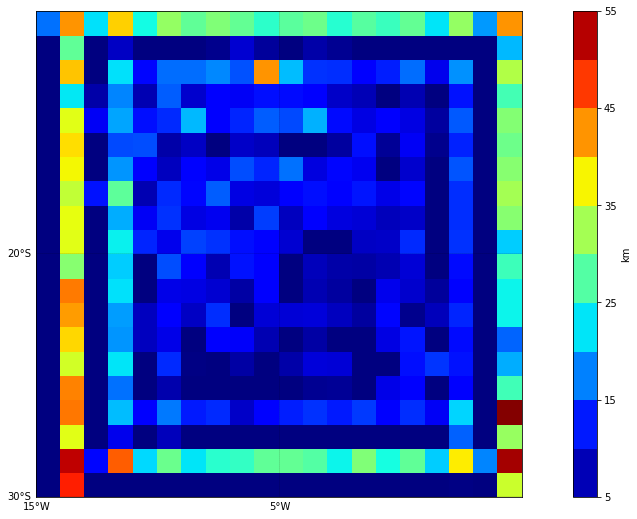

In [16]:
plot_data(moho_save[:,0],moho_save[:,1],moho_save[:,2],vmin=5,vmax=55,levels=11, cblabel='km')

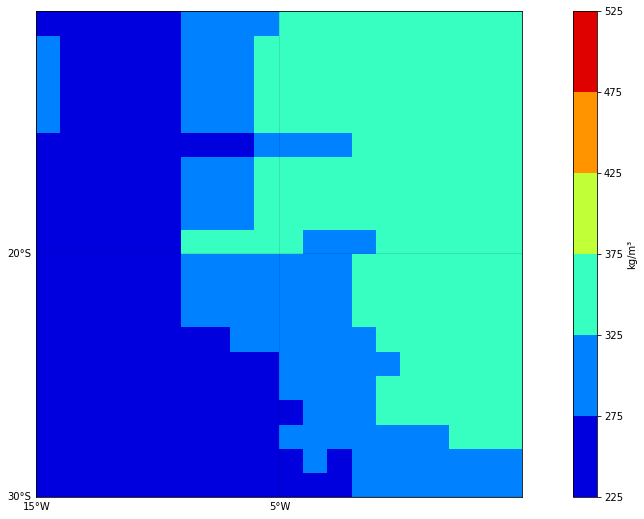

In [17]:
plot_data(density_save[:,0],density_save[:,1],density_save[:,2],vmin=225,vmax=525,levels=7, cblabel='kg/m³')

#### Plot distribution of the Moho models

Works only, when a large number of density contrast combination has been run. 
The plot extensions can be changed by the user

In [18]:
no_models=500 # select number of models to plot. Value should be less than 10% of all combinations 

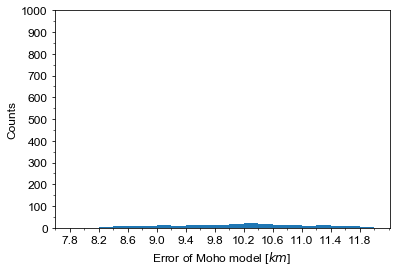

In [19]:
I = np.argsort(rms_matrix[:,1]) 
rms_matrix=rms_matrix[I,:]
bin_size=0.2
lower=np.around(np.amin(rms_matrix[:,1]))-bin_size
upper=np.around(np.amax(rms_matrix[:,1]))+bin_size
bins=np.arange(lower,upper,bin_size)
fig, ax = plt.subplots()
plt.hist(rms_matrix[:,1], bins = bins,color='lightgrey')
plt.hist(rms_matrix[0:no_models,1], bins = bins) 
plt.xticks(np.arange(lower,upper,bin_size*2),fontsize=12,fontname="Arial")
plt.yticks(np.arange(0,1001,100),fontsize=12,fontname="Arial")
ax.xaxis.set_minor_locator(MultipleLocator(bin_size))
ax.yaxis.set_minor_locator(MultipleLocator(50))
plt.xlabel('Error of Moho model [$km$]',fontsize=12,fontname="Arial")
plt.ylabel('Counts',fontsize=12,fontname="Arial")
#plt.savefig("Error_of_Moho.png", bbox_inches = 'tight', pad_inches = 0,dpi=300,transparent=True)
plt.show()

#### Prepare inverted density contrasts

In [20]:
values=np.around(np.arange(0,number_of_units+0.1-1,1))
dens_counts=np.zeros((0,2))
for i in values:
    unique, counts = np.unique(rms_matrix[0:no_models,int(i)+5], return_counts=True)
    val=np.array((unique,counts)).T
    if val[0,0]!=dens_min:
        fill=np.arange(dens_min,val[0,0],dens_inc)
        fill=np.array((fill,np.zeros(len(fill)))).T
        val=np.concatenate((fill,val),axis=0)
    if val[-1,0]!=dens_max:
        fill=np.arange(val[-1,0]+dens_inc,dens_max+0.1,dens_inc)
        fill=np.array((fill,np.zeros(len(fill)))).T
        val=np.concatenate((val,fill),axis=0)
    dens_counts=np.append(dens_counts,val,axis=0)

#### Plot distribution of inverted density contrasts

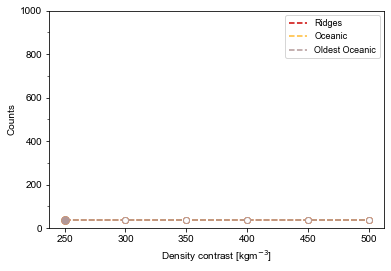

In [21]:
rgb_values=np.array(([61.0,204.0,75.0],[0.0,64.0,255.0],[167.0,186.0,209.0],
                     [204.0,3.0,0.0],[255.0,187.0,51.0],[178.0,152.0,152.0]))/255

fig,ax = plt.subplots()
labels=["Craton","Precambrian Belt","Phanerozoic","Ridges","Oceanic","Oldest Oceanic"]
for i,ii in enumerate(value_of_units):
    comb=dens_counts[i*len(k):len(k)*(i+1),:]
    plt.plot(comb[:,0], comb[:,1], '--', color=(rgb_values[int(ii)-1]),label=labels[int(ii)-1])
    plt.plot(comb[:,0], comb[:,1], '.',markersize=12, color="white", markeredgecolor=(rgb_values[int(ii)-1]))
    plt.plot(comb[np.argmax(comb[:,1]),0],comb[np.argmax(comb[:,1]),1],'.',markersize=15,color=(rgb_values[int(ii)-1]))

ax.yaxis.set_minor_locator(MultipleLocator(100))
plt.xticks(k,fontsize=10,fontname="Arial")
plt.yticks(np.arange(0,1001,200),fontsize=10,fontname="Arial")
plt.xlabel('Density contrast [kgm$^{-3}$]',fontsize=10,fontname="Arial")
plt.ylabel('Counts',fontsize=10,fontname="Arial")
font = font_manager.FontProperties(family='Arial',size=9)
plt.legend(prop=font)
#plt.savefig("Distribution_density_contrasts.png", bbox_inches = 'tight', pad_inches = 0,dpi=300)
plt.show()